## Network-based precisionist painter, hopefully?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from IPython.display import display
import tensorflow as tf
import itertools

ToDo points:

* Switch to perceptual color
* Train on only one textured image, overfit
* If doesn't work well, consider fitting in BW
* If HDRing photos is easy, HDR them
* Learn to load weights into a layer. Then train brushes with fewer brushes (2-3 only, for a small piece of an image?)

Open questions and action points:

* How to save checkpoints?
* Do I actually want to overfit? How would regularization feel aesthetically in this case?
* How to decide when to stop? Can we stop based on improvement or loss, not nEpochs alone?
* What is the optimal batch size?
* Use Keras optimizer to grid search through these hyperparameters?
* Replace final layer with a custom output layer that takes NBrushes*BrushDescription, and then predicts this y from these brushes
* Some operations during training are place on GPU, but is the current process optimal? What would be a benchmark here?
* Is it possible not just load pre-trained models, but noisify them?
* Is there a benefit in noisifying only those weights that were driven to 0? (By regularizations?)

In [7]:
print("GPU support:", tf.test.is_gpu_available())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# tf.debugging.set_log_device_placement(True) # To force reporting of CPU/GPU placement for individual operations

GPU support: True
Num GPUs Available:  1


../pics-in/IMG_20180818_184007.jpg


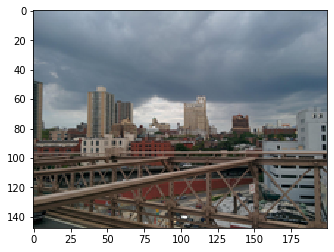

In [8]:
# Read and transform some image
def loadImage(i=0, targetSize=(100,200)):
    '''
    targetSize: will be downsampled to this (y,x). The smallest of dimensions defines the output size.
    '''
    inFolder = '../pics-in/'
    fileList = os.listdir(inFolder)
    fileName = inFolder + fileList[i] # Read the first image alphabetically, for now
    # fileName = inFolder + "road.jpg"
    print(fileName)
    im = Image.open(fileName)

    im.thumbnail(targetSize, Image.ANTIALIAS)
    # im = im.convert('L') # 1 for BW dither; L for grayscale; LAB and HSV may be interesting for the future
    im = im.convert('RGB')
    # display(im) # Faithful representation
    return im

class holder():
    i = None
    modelName = ''
    h = None
    w = None

z = holder()
z.i = 0
im = loadImage(z.i , (200,400))
plt.imshow(im) # Mathy representation (grayscales get pseudocolored)

In [9]:
def image_to_data(im,z):
    y = np.array(im)
    (h,w,_) = y.shape
    y = y.reshape((h*w,3))
    _x,_y = np.meshgrid(np.array(range(w))/w, np.array(range(h))/h)
    x = np.transpose(np.vstack([_x.flatten() , _y.flatten()]))
    z.h = h
    z.w = w
    return (x,y,z)

(x,y,z) = image_to_data(im,z)

print(x.shape)
print(y.shape)

(29600, 2)
(29600, 3)


One idea for the model would be to use 1 dense layer 2>N to create create N different gradients. Then the 2nd dense layer can combine these gradient into areas. Exactly like it happens with building a classifyer.

Some info on Conv1D: it works with 3D arrays, where the 1st dim is the batch dim, the 2nd one is kernel size (how many consecutive points to warp together), and the 3d one is the number of channels. In the constructor, the last two dimensions go in the opposite order (first nChannels that they call "filters", then kernel_size). And it really insists on getting a 3D input, even if some dimensions are singleton, so it may necessitate a reshaping with dimension expansion.

For this project, Conv1D is only helpful if we have several brushes that will all get same input information (scaled distance from each of the lines thrown around by the first dense layer). If each convolutional brush gets info from a different line, the model will be forced to use the same brush for visualizing each of the lines.

In [24]:
def build_model(z):
    option = 3
    if option==1:
        z.modelName = "128r32r3r"
        # Trainable params: 4,611
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu', input_shape=(2,)),
            tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.001)),
            tf.keras.layers.Dense(3, activation='relu')
        ])
    elif option==2:
        z.modelName = '128r64r32r32h8r8r'
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu', input_shape=(2,)),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(32, activation='hard_sigmoid'),
            #tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(8, activation='relu'),
            tf.keras.layers.Dense(8, activation='relu'),
            tf.keras.layers.Dense(3, activation='linear')
        ])
    elif option==3:
        z.modelName = "32brush_64conv_maxpool"
        nBrushes = 32 # Should be low-ish, to keep the pic abstract
        nParams = 64 # Params per brush (should be high, to keep brushes high-res)
        # Trainable params: 14,692
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(nBrushes*nParams, activation='relu', input_shape=(2,)),
            tf.keras.layers.Reshape((nBrushes,nParams)),
            tf.keras.layers.Conv1D(nParams, 1, activation='relu'), # applied to each vector of params separately (thus 1)
            tf.keras.layers.Conv1D(nParams, 1, activation='relu'),
            tf.keras.layers.Conv1D(3, 1, activation='relu'), # Output layer for the convolutional part: RGB
            tf.keras.layers.Permute((2,1)), # unorthodox use of pooling here: not in space, but across filters
            tf.keras.layers.MaxPooling1D(pool_size = (nBrushes),data_format='channels_first'), # pick one brush
            tf.keras.layers.Reshape((3,))
        ])
    elif option==4:
        z.modelName = "32brush_256x2conv"
        nBrushes = 32 # Should be low-ish, to keep the pic abstract
        nParams = 256 # Params per brush (should be high, to keep brushes high-res)
        # Trainable params: 14,692
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(nBrushes*nParams, activation='relu', input_shape=(2,)),
            tf.keras.layers.Reshape((nBrushes,nParams)),
            tf.keras.layers.Conv1D(nParams, 1, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.001)), # applied to each vector of params separately (thus 1)
            tf.keras.layers.Conv1D(nParams, 1, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.001)),
            tf.keras.layers.Conv1D(3, 1, activation='relu'), # Output layer for the convolutional part: RGB
            tf.keras.layers.Conv1D(1,1, activation='linear', data_format='channels_first'), # Mix all brushes
            tf.keras.layers.Reshape((3,))
        ])
    elif option==5:
        z.modelName = "128c32c3c"
        # For Conv1D it's dim_In, dim_Out (they call it filters, kernelsize)
        # Trainable params: 4,611 (right now, exactly as in the deep network #1)
        model = tf.keras.Sequential([
            tf.keras.layers.Reshape((1,2), input_shape=(2,)), # Reshapes from 2D to fake 3D for Conv1D to work?
            tf.keras.layers.Conv1D(128, 1, activation='relu'),
            tf.keras.layers.Conv1D(32, 1, activation='relu'),
            tf.keras.layers.Conv1D(3, 1, activation='relu'),
            #tf.keras.layers.Conv1D(1,1, activation='linear', data_format='channels_first'),
            tf.keras.layers.Reshape((3,))
        ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
    #optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0) # Reduces learning rate
    # ADAM (at least with the default set of params, and with learning_rate=0.02)
    # doesn't work with hard sigmoid functions. After original descent, it overupdates them to oblivion,
    # and then gets trapped in some pathological solution. Adadelta works with hard sigmoids.

    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mse'])
    
    return (model,z)

(model,z) = build_model(z)
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 2048)              6144      
_________________________________________________________________
reshape_24 (Reshape)         (None, 32, 64)            0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 32, 64)            4160      
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 32, 64)            4160      
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 32, 3)             195       
_________________________________________________________________
permute (Permute)            (None, 3, 32)             0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 3, 1)            


..................................................

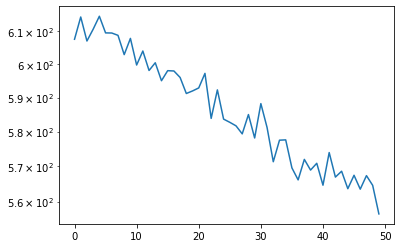

In [29]:
# Train the model:

class PrintDot(tf.keras.callbacks.Callback): # Copied from the manual; is called after each epoch
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
        
if True:
    history = model.fit(x,y,epochs=50,batch_size=32,verbose=0,callbacks=[PrintDot()],shuffle=True)
    # 32 is the default batch size, apparently

    ax = plt.axes()
    ax.plot(history.history['loss'])
    ax.set_yscale('log')

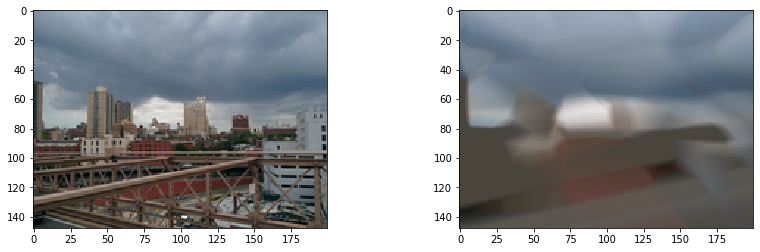

In [30]:
# This section is for troubleshooting; the big pic below doesn't depend on it
y_new = model.predict(x)
y_new = np.minimum(255,np.maximum(0,y_new))/255
#y_new = (y_new-np.min(y_new))/(np.max(y_new)-np.min(y_new))

%matplotlib inline
fig, axs = plt.subplots(1,2);
fig.set_figwidth(14,5);
axs[0].imshow(y.reshape((z.h,z.w,3)));
axs[1].imshow(y_new.reshape((z.h,z.w,3)));

In [7]:
# Freeze all layers except the very first one

def freezeModel(model, trainable=False):
    if trainable:
        print('Thawing convolutional layers')
    else:
        print('Freezing convolutional layers')
    i = 0
    for layer in model.layers:
        if i>0:
            layer.trainable = trainable
        i += 1

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])
    return model

#model = freezeModel(model)
#model.summary()

In [31]:
def generateIm(x,y,model,z):
    upsample_coeff = 6
    hb = z.h*upsample_coeff
    wb = z.w*upsample_coeff
    _x,_y = np.meshgrid(np.array(range(wb))/wb, 
                        np.array(range(hb))/hb)
    xbig = np.transpose(np.vstack([_x.flatten() , _y.flatten()]))
    y_big = model.predict(xbig)
    y_big = np.minimum(255,np.maximum(0,y_big))/255
    #y_big = np.minimum(255,np.maximum(0,y_big)).astype(int)
    y_big = y_big.reshape((hb,wb,3))
    y_big.shape

    img = Image.fromarray(np.uint8(255*y_big),"HSV") # Without this weird uint8 type-casting, doesn't work
    img = img.convert('RGB')
    return img
    
#im2 = generateIm(x,y,model,z)
#display(im2)

In [9]:
def saveIm(im,z):
    outFolder = '../pics-out/'
    outFileName = outFolder + "pic_%s_%d.jpg" % (z.modelName,z.i)
    print("Saving:",outFileName)
    im.save(outFileName,"jpeg")
            
# saveIm(im2,z)

## Semi-manual cycle

Plan for the future: abstract, so that I could order n epochs on each pic. Then train (curriculum) with a suboptimal number of epochs (50?) on a series of increasigly fancy abstract pics (curriculum :) . Then abstract "freeze" command, and go through fitting normal pics.

In [ ]:
%matplotlib inline
print("Model name:",z.modelName)
# We assume that the model is frozen
for i in range(2,11):
    z.i = i
    targetSize = (100,200)
    nEpochs = 500        
    try:
        im = loadImage(z.i, targetSize)
    except: # If it couldn't load the pic, give up
        print('Problem with loading file') 
        break
    (x,y,z) = image_to_data(im,z)       
    history = model.fit(x,y,epochs=nEpochs,batch_size=32,verbose=0,callbacks=[PrintDot()],shuffle=True)
    im2 = generateIm(x,y,model,z)
    saveIm(im2,z)

## Fully automated cycle

Model name: 32brush_256x2conv
../pics-in/a2.jpg

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

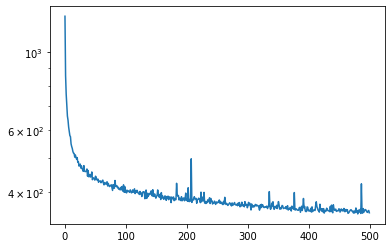


 Generating final image
Saving: ../pics-out/pic_32brush_256x2conv_0.jpg
../pics-in/IMG_20180818_184007.jpg
Freezing convolutional layers

....................................................................................................
....................................................................................................
....................................................................................................

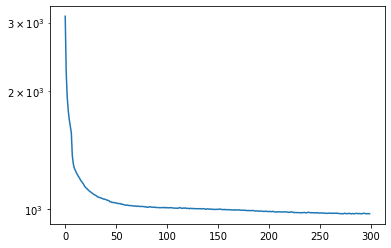


 Generating final image
Saving: ../pics-out/pic_vanguard3_1.jpg
../pics-in/IMG_20180826_160044.jpg

....................................................................................................
....................................................................................................
....................................................................................................

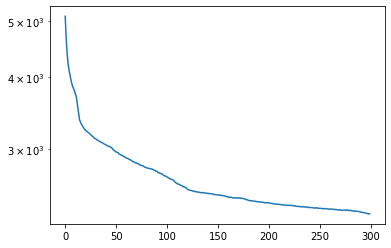


 Generating final image
Saving: ../pics-out/pic_vanguard3_2.jpg
../pics-in/IMG_20190111_081210.jpg

....................................................................................................
....................................................................................................
....................................................................................................

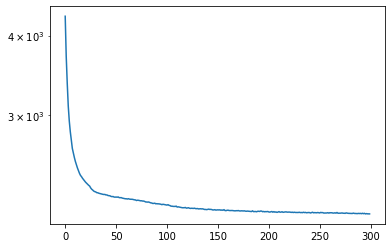


 Generating final image
Saving: ../pics-out/pic_vanguard3_3.jpg
../pics-in/IMG_20190424_084800.jpg

....................................................................................................
....................................................................................................
....................................................................................................

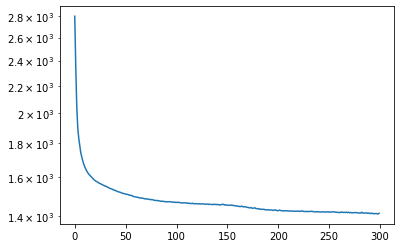


 Generating final image
Saving: ../pics-out/pic_vanguard3_4.jpg
../pics-in/IMG_20190520_202407.jpg

....................................................................................................
....................................................................................................
....................................................................................................

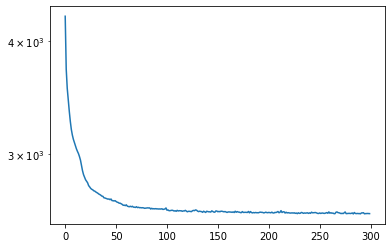


 Generating final image
Saving: ../pics-out/pic_vanguard3_5.jpg
../pics-in/IMG_20190607_204444.jpg

....................................................................................................
....................................................................................................
....................................................................................................

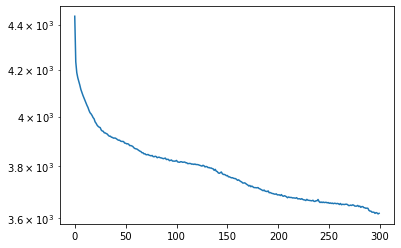


 Generating final image
Saving: ../pics-out/pic_vanguard3_6.jpg
../pics-in/IMG_20190701_143057.jpg

....................................................................................................
....................................................................................................
....................................................................................................

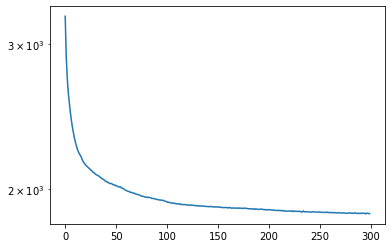


 Generating final image
Saving: ../pics-out/pic_vanguard3_7.jpg
../pics-in/IMG_20190818_173952.jpg

....................................................................................................
....................................................................................................
....................................................................................................

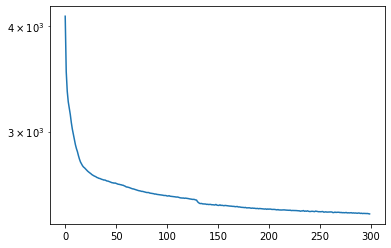


 Generating final image
Saving: ../pics-out/pic_vanguard3_8.jpg
../pics-in/IMG_20191015_174802.jpg

....................................................................................................
....................................................................................................
....................................................................................................

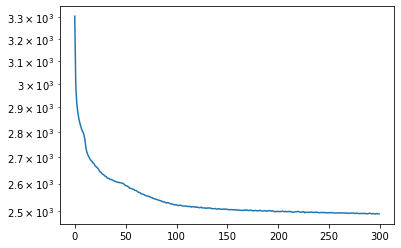


 Generating final image
Saving: ../pics-out/pic_vanguard3_9.jpg
../pics-in/road.jpg

....................................................................................................
....................................................................................................
....................................................................................................

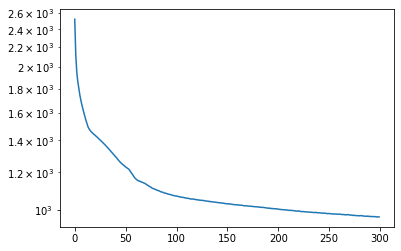


 Generating final image
Saving: ../pics-out/pic_vanguard3_10.jpg
../pics-in/sky.jpg

....................................................................................................
....................................................................................................
....................................................................................................

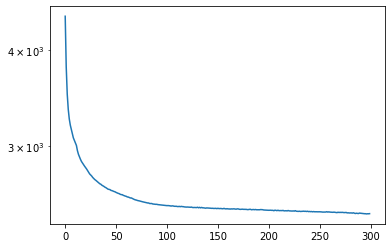


 Generating final image
Saving: ../pics-out/pic_vanguard3_11.jpg


In [35]:
%matplotlib inline

# Fully automated cycle
totalImages = 12
iToStopLearning = 1 # First pic (0-indexed) to not learn
nEpochsScale = 100

z = holder()
(model,z) = build_model(z)
print("Model name:",z.modelName)
for i in range(totalImages):
    z.i = i
    if i<iToStopLearning:
        targetSize = (200,400)
    else:
        targetSize = (100,200)
        z.modelName = 'vanguard3'
        
    try:
        im = loadImage(z.i, targetSize)
    except: # If it couldn't load the pic, give up
        print('Problem with loading file') 
        break
    (x,y,z) = image_to_data(im,z)
    
    if i<iToStopLearning:
        if i>0: # For the very first picture, we should train everything, so skip this part
            # First sketch position of brushes:
            model = freezeModel(model, trainable=False)
            history = model.fit(x,y,epochs=nEpochsScale*2,batch_size=32,verbose=0,callbacks=[PrintDot()],shuffle=True)
            # Then improve brushes as well
            model = freezeModel(model, trainable=True)
        history = model.fit(x,y,epochs=nEpochsScale*5,batch_size=32,verbose=0,callbacks=[PrintDot()],shuffle=True)
    else:
        if i==iToStopLearning: # Now brushes will stay frozen forever
            model = freezeModel(model)
        history = model.fit(x,y,epochs=nEpochsScale*3,batch_size=32,verbose=0,callbacks=[PrintDot()],shuffle=True)
        
    ax = plt.axes()
    ax.plot(history.history['loss'])
    ax.set_yscale('log')
    plt.show()
    print('\n Generating final image')
    im2 = generateIm(x,y,model,z)
    saveIm(im2,z)